# Curso: Aprendizaje Automático
# Trabajo Práctico 6

Profesor: Luis Alexánder Calvo Valverde

Instituto Tecnológico de Costa Rica

Programa Ciencia de Datos

---

Fecha de entrega: Lunes 25 de Noviembre 2024, a más tardar a las 3:00 pm.

Medio de entrega: Por medio del TEC-Digital.

Entregables: Un archivo jupyter ( .IPYNB ) y todos los archivos adiconales que se requieran para correr su Cuaderno (En un archivo comprimido)

Estudiante:
1. **Agustin Vargas Quesada**

# Experimentación con regresión

Indicaciones generales que deben seguir:
1. Se le proporcionan el conjunto de datos y un archivo de texto con una breve explicación de las columnas (esta es la versión del dataset que debe usar, **no busque similares en internet**).
1. Realizarán regresión y el atributo a predecir es: "price".
1. Para que vayan experimentando lo que se vive en esta disciplina, Ustedes deben ir tomando las decisiones en el proceso y documentarlas en celdas de texto y además su código debe venir ampliamente comentado. Recuerden que el profesor hace de cliente por si tienen dudas.
1. Deben dividir el dataset en tres conjuntos de datos: train (60%), validation (20%) y test (20%).
1. La red propuesta debe tener al menos dos capas ocultas.
1. Ustedes proponen el diseño experimental (quiero ver qué han entendido de este concepto fundamental en data science).

Criterios de evaluación:
1. Deben presentar una implementación completa. (**70 puntos**)
1. Documentación de decisiones en celdas de texto y comentarios al código. (**20 puntos**)
1. Conclusiones finales: En una celda de código al final del cuaderno, incluya sus conclusiones más importantes del experimento. (**10 puntos**)



## Analisis del data set diamonds

In [78]:
!pip install tabulate
!pip install tensorflow
!pip install scikeras

In [80]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from matplotlib import pyplot
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

In [63]:
# Cargar el archivo
df = pd.read_csv('diamonds_USAR.csv', delimiter=',')

In [64]:
print(tabulate(df.head(5), headers='keys', tablefmt='grid'))

+----+------+---------+---------+-----------+---------+---------+---------+------+------+------+
|    |   id |   carat | cut     | clarity   |   depth |   table |   price |    x |    y |    z |
+====+======+=========+=========+===========+=========+=========+=========+======+======+======+
|  0 |    1 |    0.23 | Ideal   | SI2       |    61.5 |      55 |     326 | 3.95 | 3.98 | 2.43 |
+----+------+---------+---------+-----------+---------+---------+---------+------+------+------+
|  1 |    2 |    0.21 | Premium | SI1       |    59.8 |      61 |     326 | 3.89 | 3.84 | 2.31 |
+----+------+---------+---------+-----------+---------+---------+---------+------+------+------+
|  2 |    3 |    0.23 | Good    | VS1       |    56.9 |      65 |     327 | 4.05 | 4.07 | 2.31 |
+----+------+---------+---------+-----------+---------+---------+---------+------+------+------+
|  3 |    4 |    0.29 | Premium | VS2       |    62.4 |      58 |     334 | 4.2  | 4.23 | 2.63 |
+----+------+---------+-------

In [65]:
missing_values = df.isnull().sum()
print(missing_values)

id         0
carat      0
cut        0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


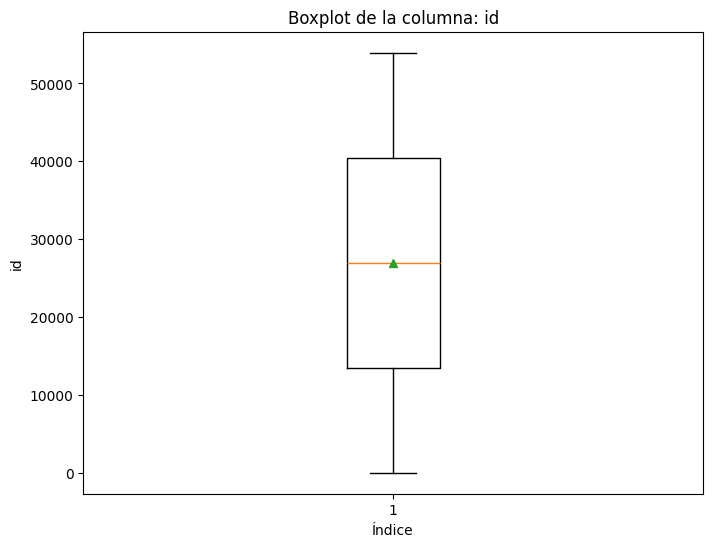

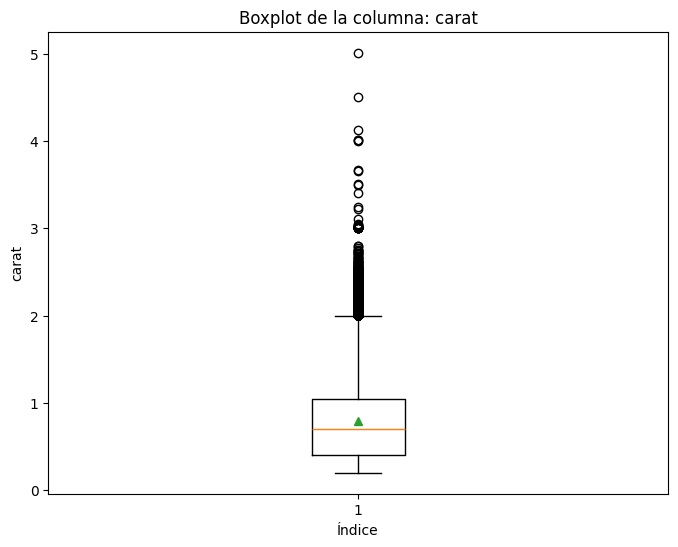

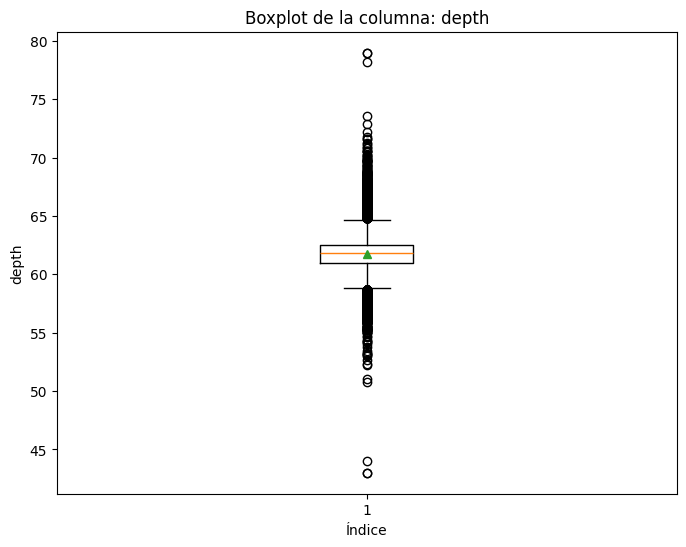

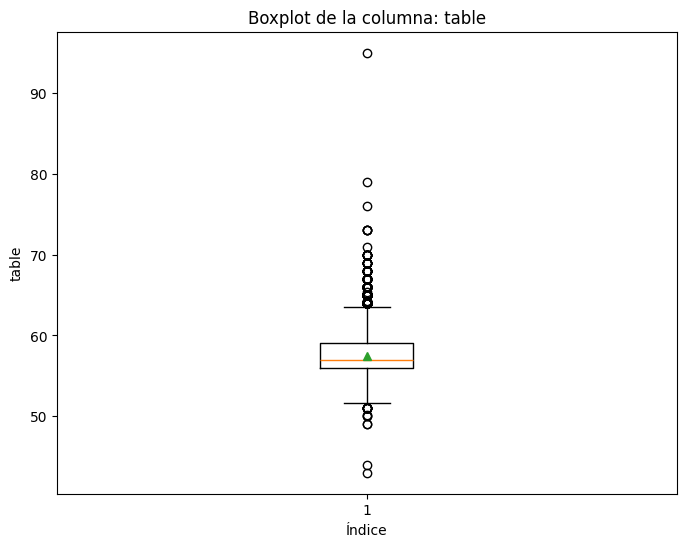

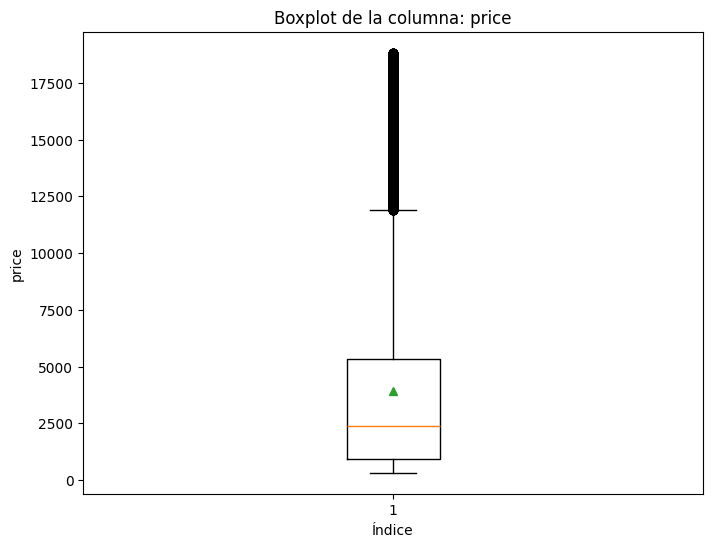

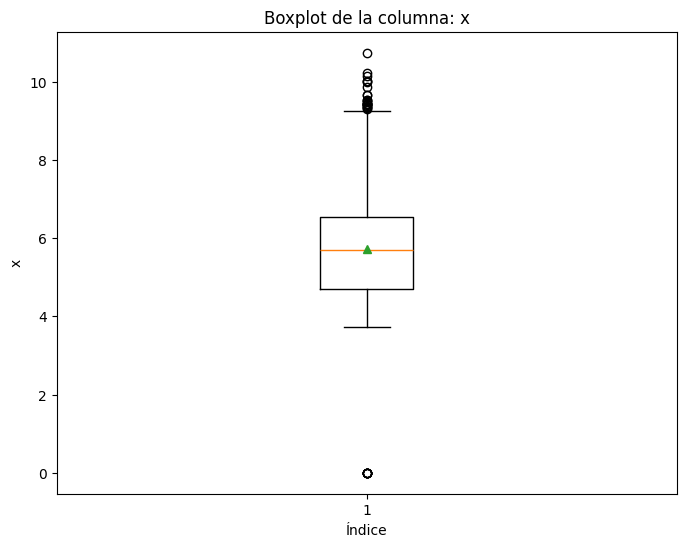

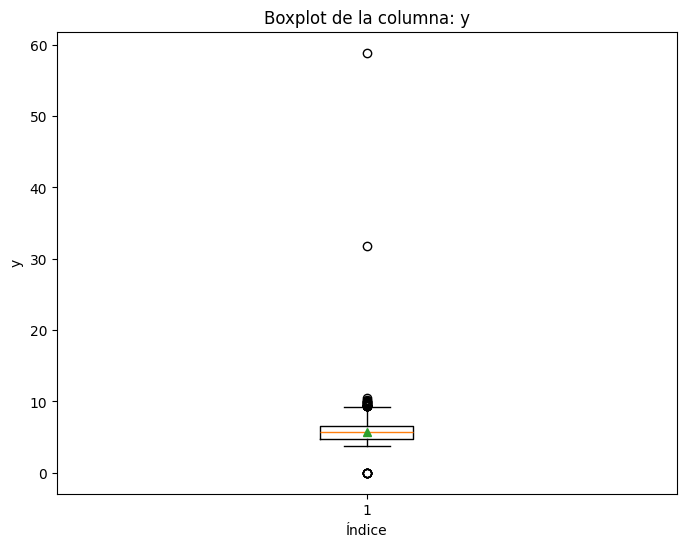

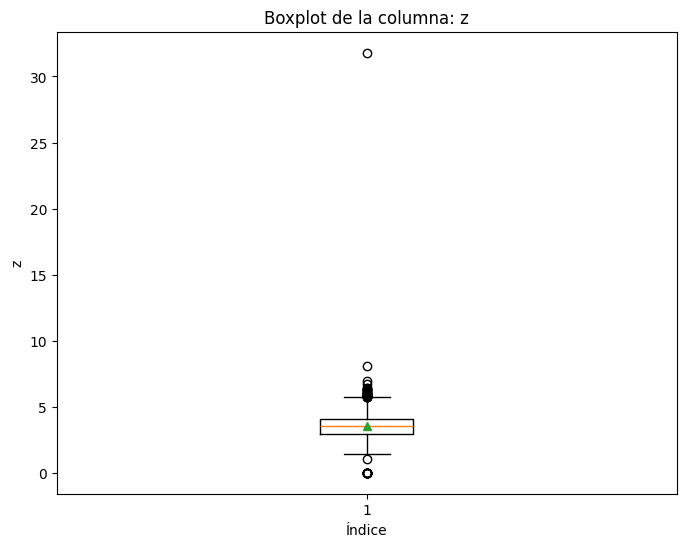

In [66]:
def visualizar_boxplot_por_columna(df):
    # Seleccionar solo columnas numéricas
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Crear un boxplot para cada columna numérica
    for column in numeric_columns:
        pyplot.figure(figsize=(8, 6))
        pyplot.boxplot(df[column], showmeans=True)
        pyplot.title(f'Boxplot de la columna: {column}')
        pyplot.xlabel('Índice')
        pyplot.ylabel(column)
        pyplot.show()

visualizar_boxplot_por_columna(df)

In [67]:
def cantidad_outliers_por_columna(df):
    # Seleccionar solo columnas numéricas
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Calcular outliers para cada columna numérica
    for columna in numeric_columns:
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identificar los outliers
        outliers = df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]
        print(f"Número de outliers en la columna {columna}: {len(outliers)}")

cantidad_outliers_por_columna(df)

Número de outliers en la columna id: 0
Número de outliers en la columna carat: 1889
Número de outliers en la columna depth: 2545
Número de outliers en la columna table: 605
Número de outliers en la columna price: 3540
Número de outliers en la columna x: 32
Número de outliers en la columna y: 29
Número de outliers en la columna z: 49


In [68]:
def cantidad_ceros (dataset, columns):
    num_cero_values = (dataset[columns] == 0).sum()
    return num_cero_values

num_cero_values = cantidad_ceros (df,['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut'])

print("===== Columnas con ceros =====")
print(num_cero_values)

===== Columnas con ceros =====
carat     0
depth     0
table     0
price     0
x         8
y         7
z        20
cut       0
dtype: int64


Se realizo un analisis sobre el dataset y podemos concluir:
- Posee varios valores outliers que se deben de tratar.
- Posee una columnas la cual se podria eliminar que es el id, ya que esta no aporta nada.
- No posee tantos valores en cero ya que solo 3 columnas posee valores en cero y con muy pocos datos.

## Preprocesamiento de los datos

In [69]:
df = df.drop('id', axis=1)
print(tabulate(df.head(5), headers='keys', tablefmt='grid'))

+----+---------+---------+-----------+---------+---------+---------+------+------+------+
|    |   carat | cut     | clarity   |   depth |   table |   price |    x |    y |    z |
+====+=========+=========+===========+=========+=========+=========+======+======+======+
|  0 |    0.23 | Ideal   | SI2       |    61.5 |      55 |     326 | 3.95 | 3.98 | 2.43 |
+----+---------+---------+-----------+---------+---------+---------+------+------+------+
|  1 |    0.21 | Premium | SI1       |    59.8 |      61 |     326 | 3.89 | 3.84 | 2.31 |
+----+---------+---------+-----------+---------+---------+---------+------+------+------+
|  2 |    0.23 | Good    | VS1       |    56.9 |      65 |     327 | 4.05 | 4.07 | 2.31 |
+----+---------+---------+-----------+---------+---------+---------+------+------+------+
|  3 |    0.29 | Premium | VS2       |    62.4 |      58 |     334 | 4.2  | 4.23 | 2.63 |
+----+---------+---------+-----------+---------+---------+---------+------+------+------+
|  4 |    

In [70]:
def reemplazar_ceros_con_media(df):
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    for column in numeric_columns:
        mean = df[df[column] != 0][column].mean()
        zeros_mask = df[column] == 0
        
        if df[column].dtype == 'int64':
            df[column] = df[column].astype('float64')
            df.loc[zeros_mask, column] = round(mean)
            df[column] = df[column].astype('int64')
        else:
            df.loc[zeros_mask, column] = round(mean, 2)
    
    return df

reemplazar_ceros_con_media(df)
num_cero_values = cantidad_ceros (df,['carat', 'cut', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z'])

print("===== Columnas con ceros =====")
print(num_cero_values)

===== Columnas con ceros =====
carat      0
cut        0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


In [71]:
def manejo_outliers(df, std_thresh=2):
    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:
            mean = df[column].mean()
            std = df[column].std()
            outliers = np.abs(df[column] - mean) > std_thresh * std
            
            if df[column].dtype == 'int64':
                mean_int = int(round(mean))
                df.loc[outliers, column] = mean_int
            else:
                df.loc[outliers, column] = round(mean, 2)
    
    return df
    
manejo_outliers(df)
cantidad_outliers_por_columna(df)


Número de outliers en la columna carat: 0
Número de outliers en la columna depth: 1074
Número de outliers en la columna table: 30
Número de outliers en la columna price: 1919
Número de outliers en la columna x: 0
Número de outliers en la columna y: 0
Número de outliers en la columna z: 0


In [72]:
# Dummiers de cut
cut_dummies = pd.get_dummies(df['cut'], prefix='cut')
df = pd.concat([df, cut_dummies], axis=1)
df = df.drop('cut', axis=1)


# Dummiers de clarity
clarity_dummies = pd.get_dummies(df['clarity'], prefix='clarity')
df = pd.concat([df, clarity_dummies], axis=1)
df = df.drop('clarity', axis=1)

print(df)

       carat  depth  table  price     x     y     z  cut_Fair  cut_Good  \
0       0.23  61.50  55.00    326  3.95  3.98  2.43     False     False   
1       0.21  59.80  61.00    326  3.89  3.84  2.31     False     False   
2       0.23  61.75  57.46    327  4.05  4.07  2.31     False      True   
3       0.29  62.40  58.00    334  4.20  4.23  2.63     False     False   
4       0.31  63.30  58.00    335  4.34  4.35  2.75     False      True   
...      ...    ...    ...    ...   ...   ...   ...       ...       ...   
53935   0.72  60.80  57.00   2757  5.75  5.76  3.50     False     False   
53936   0.72  63.10  55.00   2757  5.69  5.75  3.61     False      True   
53937   0.70  62.80  60.00   2757  5.66  5.68  3.56     False     False   
53938   0.86  61.00  58.00   2757  6.15  6.12  3.74     False     False   
53939   0.75  62.20  55.00   2757  5.83  5.87  3.64     False     False   

       cut_Ideal  cut_Premium  cut_Very Good  clarity_I1  clarity_IF  \
0           True        Fal

In [73]:
def escalar_datos_robust(df, agregar_bias=False):
    # Identificar columnas numéricas (excluyendo las dummy)
    # Asumimos que las columnas dummy son booleanas o tienen '_' en su nombre
    numeric_columns = []
    dummy_columns = []
    
    for column in df.columns:
        # Si es una columna dummy (verificamos por el nombre o tipo de dato)
        if df[column].dtype == bool or '_' in column:
            dummy_columns.append(column)
            # Convertir booleanos a 0 y 1 si es necesario
            df[column] = df[column].astype(int)
        # Si es numérica y no es dummy
        elif df[column].dtype in ['float64', 'int64']:
            numeric_columns.append(column)
    
    # Aplicar RobustScaler solo a las columnas numéricas
    scaler = RobustScaler()
    if numeric_columns:
        df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    
    if agregar_bias:
        df['bias'] = 1
    
    return df

# Aplicar la función
df = escalar_datos_robust(df, agregar_bias=False)

df.to_csv('diamondsPROCESADO.csv', index=False)

Para el preprocesamiento de los datos se elimino la columna id la cual se considero que no era relevante, despues para tratar los valores que eran ceros se considera que la mejor opcion es sustiturilo por la media de estos valores, la igual que con los outliers el cual se esta utilizando de igual manera la media pero haciendo uso de std_thresh el cual nos ayuda a detectar los outliers, entre mas bajo sea el numero mejor va a ser el comportamiento, para este caso se considera que el mejor resultado es utilizando un std_thresh de 2 ya que si se utiliza un std_thresh de 1 el resultado no es lo que se espera.
Tambien ya que se va a realizar una red neuronal se posee dos columnas que no poseen valores numericos que es cut y calrity, se decidio usar el metodo dummys para clasificar esta columna con sus respectivos valores y se creo el archivo con el nombre de diamondsPROCESADO.csv para estos datos ya escalados.

## Separacion para los datos de entrenamiento, validacion y test

In [74]:
df_preprocesado = pd.read_csv('diamondsPROCESADO.csv', delimiter=',')

X_preprocesado = df_preprocesado.drop('price', axis=1)
y_preprocesado = df_preprocesado['price']

# 60% train
X_train_preprocesado, X_testVal_preprocesado, y_train_preprocesado, y_testVal_preprocesado = train_test_split(X_preprocesado, 
                                                                                                              y_preprocesado, 
                                                                                                              train_size=0.60, 
                                                                                                              shuffle=True, 
                                                                                                              random_state=30)

# 20% test, 20% validation
X_validation_preprocesado, X_test_preprocesado, y_validation_preprocesado, y_test_preprocesado = train_test_split( X_testVal_preprocesado,
                                                                                                                    y_testVal_preprocesado,
                                                                                                                    test_size=0.50,
                                                                                                                    shuffle=True,
                                                                                                                    random_state=30)



print("\nTamaño del train: ", len(X_train_preprocesado))
print("\nTamaño del validation: ", len(X_validation_preprocesado))
print("\nTamaño del test: ", len(X_test_preprocesado))
print("\nCantidad de muestras: ", len(X_train_preprocesado)+len(X_validation_preprocesado)+len(X_test_preprocesado))


Tamaño del train:  32364

Tamaño del validation:  10788

Tamaño del test:  10788

Cantidad de muestras:  53940


## Entrenamiento de la red neuronal

In [92]:
def create_model(neurons=300, hidden_layers=2, activation='relu', learning_rate=0.001):
    network = models.Sequential()
    
    # Primera capa
    network.add(layers.Dense(neurons, activation=activation, input_shape=(X_train_preprocesado.shape[1],)))
    
    # Capas ocultas
    for _ in range(hidden_layers - 1):
        network.add(layers.Dense(neurons, activation=activation))
    
    # Capa de salida (1 neurona para regresión)
    network.add(layers.Dense(1))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    network.compile(optimizer=optimizer,
                   loss='mean_squared_error',  # MSE para regresión
                   metrics=['mae'])  # Error absoluto medio como métrica
    
    return network

model = KerasRegressor(build_fn=create_model, verbose=0)

In [94]:
param_grid = {
    'model__neurons': [15, 30, 50],
    'model__hidden_layers': [2, 3],
    'batch_size': [32, 64],
    'epochs': [15, 40]
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Iniciando búsqueda de hiperparámetros...")
grid_result = grid.fit(X_train_preprocesado, y_train_preprocesado)

Iniciando búsqueda de hiperparámetros...
Fitting 3 folds for each of 24 candidates, totalling 72 fits


C:\Users\varga\anaconda3\envs\CursoMachineLearning\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\varga\anaconda3\envs\CursoMachineLearning\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [96]:
print("Mejores hiperparámetros:", grid_result.best_params_)
print("Mejor puntuación:", grid_result.best_score_)

# Creamos el mejor modelo usando los parámetros encontrados
best_model = create_model(
    neurons=grid_result.best_params_['model__neurons'],
    hidden_layers=grid_result.best_params_['model__hidden_layers']
)

# Entrenamos el modelo con los mejores parámetros
history = best_model.fit(
    X_train_preprocesado,
    y_train_preprocesado,
    epochs=grid_result.best_params_['epochs'],
    batch_size=grid_result.best_params_['batch_size'],
    validation_data=(X_validation_preprocesado, y_validation_preprocesado)
)


Mejores hiperparámetros: {'batch_size': 32, 'epochs': 40, 'model__hidden_layers': 2, 'model__neurons': 15}
Mejor puntuación: 0.8406311531886609
Epoch 1/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2107 - mae: 0.2834 - val_loss: 0.1173 - val_mae: 0.1971
Epoch 2/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1224 - mae: 0.1960 - val_loss: 0.1056 - val_mae: 0.1847
Epoch 3/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1063 - mae: 0.1826 - val_loss: 0.1002 - val_mae: 0.1761
Epoch 4/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0999 - mae: 0.1752 - val_loss: 0.0992 - val_mae: 0.1762
Epoch 5/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0991 - mae: 0.1734 - val_loss: 0.0963 - val_mae: 0.1707
Epoch 6/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0973 - mae: 0.1716 - val_loss: 0.0957 - val_mae: 0.1727
Epoch 7/40
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0990 - mae: 0.1721 - val_loss: 0.0956 - val_mae: 0.1719
Epoch 8/40
1012/

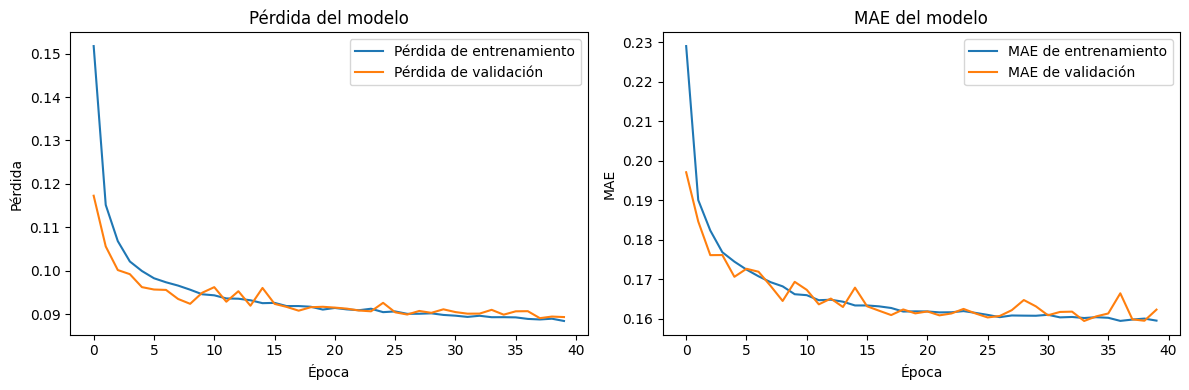

338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 0.0901 - mae: 0.1644
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step

Pérdida en validación: 0.08936478942632675
MAE en validación: 0.1623651534318924

Resultados finales:
Pérdida en entrenamiento: 0.08715739846229553
Pérdida en test: 0.09315910935401917
MAE en entrenamiento: 0.16065941751003265
MAE en test: 0.16402728855609894


In [100]:
plt.figure(figsize=(12, 4))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

# Gráfica de MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE de entrenamiento')
plt.plot(history.history['val_mae'], label='MAE de validación')
plt.title('MAE del modelo')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluamos en el conjunto de validación
val_loss, val_mae = best_model.evaluate(X_validation_preprocesado, y_validation_preprocesado)
y_train_pred = best_model.predict(X_train_preprocesado)
y_test_pred = best_model.predict(X_test_preprocesado)
print(f"\nPérdida en validación: {val_loss}")
print(f"MAE en validación: {val_mae}")
print(f"\nResultados finales:")
print(f"Pérdida en entrenamiento: {train_loss}")
print(f"Pérdida en test: {test_loss}")
print(f"MAE en entrenamiento: {train_mae}")
print(f"MAE en test: {test_mae}")

Basado en los resultados finales, el modelo muestra un rendimiento consistente a través de todos los conjuntos de datos. En el conjunto de entrenamiento, alcanzó una pérdida de 0.0872 (8.72%) y un MAE de 0.1607 (16.07%). Cuando se evaluó en el conjunto de test, obtuvo una pérdida de 0.0932 (9.32%) y un MAE de 0.1640 (16.40%). La similitud entre los valores de entrenamiento y test nos indica que el modelo ha logrado un buen balance, evitando tanto el sobreajuste como el subajuste. El rendimiento en validación, con una pérdida de 0.0894 (8.94%) y un MAE de 0.1624 (16.24%), se encuentra entre los valores de entrenamiento y test, esto nos indica que el modelo tiene un buen rendimiento.